In [1]:
#| output: false
library(tidyverse)
library(rstatix)
library(easystats)
library(ggfortify)
library(pubh)
library(sjlabelled)

jama = ggsci::scale_color_jama()
import::from(latex2exp, TeX)
import::from(epiDisplay, ci)
theme_set(see::theme_lucid(base_size = 10))
options('huxtable.knit_print_df' = FALSE)
options('huxtable.autoformat_number_format' = list(numeric = "%5.2f"))

library("repr")
options(repr.plot.width = 6, repr.plot.height = 4)

── Attaching core tidyverse packages ─────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter


# Attaching packages: easystats 0.7.2 (red = needs update)
✔ bayestestR  0.13.2   ✔ correlation 0.8.5 
✔ datawizard  0.11.0   ✖ effectsize  0.8.8 
✔ insight     0.20.1   ✔ modelbased  0.8.8 
✔ performance 0.12.0   ✔ parameters  0.22.0
✔ report      0.5.8    ✔ see         0.8.4 

Restart the R-Session and update packages with `easystats::easystats_update()`.


Loading r

# Overview

In this laboratory, we will learn about hypothesis testing, in particular, one-sample $t$-tests, and two-sample $t$-tests for means.

Once you have completed this laboratory, you should feel comfortable:

-   Generating confidence intervals for means.
-   Performing one-sample $t$-tests against a hypothesised mean.
-   Performing two-sample $t$-tests, using either paired or independent samples.
-   Performing non-parametric tests on continuous outcomes

## Summary of New Commands

| **Command**      | **Library** | **Function**                                        |
|------------------|-------------|-----------------------------------------------------|
| **gen_bst_df**   | *pubh*      | Estimates confidence intervals by group             |
| **shapiro_test** | *rstatix*   | Performs the Shapiro-Wilk normality test            |
| **TeX**          | *latex2exp* | Converts *LaTeX* expressions for use in plot labels |
| **var.test**     | *stats*     | Performs variance ratio test                        |
| **wilcox_test**  | *rstatix*   | Performs Wilcoxon-Mann-Whitney test                 |

# Confidence Intervals around the Mean

Let's take a look at the head of the data:

In [2]:
data(Bernard)
Bernard |> data_codebook()

ID,Name,Label,Type,Missings,Values,N,Prop,.row_id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,id,ID,numeric,0 (0.0%),"[1, 455]",455,,1
,,,,,,,,1
2,treat,Treatment,categorical,0 (0.0%),Placebo,231,50.8%,2
,,,,,Ibuprofen,224,49.2%,2
,,,,,,,,2
3,race,Ethnicity,categorical,0 (0.0%),White,293,64.4%,3
,,,,,African American,130,28.6%,3
,,,,,Other,32,7.0%,3
,,,,,,,,3


We start by saving the label for baseline temperature in a new variable:

In [3]:
btemp = TeX("Baseline Temperature ($^{\\degree}$C)")

::: callout-note

The function `TeX` allows us to include symbols and mathematical expressions in plots and labels using *LaTeX* syntax. *LaTeX* commands are declared between two dollar signs. Special symbols, like Greek letters, use `\`. In `Markup` documents, you only use one `\` (the standard in *LaTeX*), but in `R` functions, you need to use two instead of one, hence `$\\degree$` produces $^{\circ}$. Besides `$\degree$`, the most common symbols are Greek letters, for example, `$\\alpha$` produces $\alpha$ in `R` functions.

:::

::: callout-caution
## Exercise
Construct a histogram of baseline temperatures in $^{\circ}C$ with a normal curve superimposed.

:::

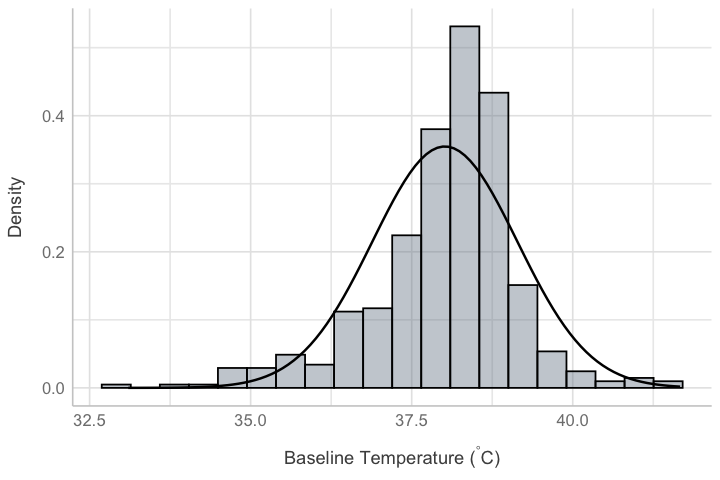

In [4]:
#| label: fig-fig1
#| fig-cap: "Distribution of baseline temperature from the Bernard data set."
#| code-fold: true
Bernard |>
  hist_norm(~ temp0, fill = "slategray", bins = 20, xlab = btemp)

We will now estimate a 95% confidence interval for mean baseline temperature for all patients.

In [5]:
Bernard %$% ci(temp0) |> round(2)

,n,mean,sd,se,lower95ci,upper95ci
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
,455,38.01,1.13,0.05,37.91,38.12


## Bootstrap

Recall that the distribution of samples follows a normal distribution. For example, the distribution of means follows a normal distribution. If we obtain, for instance, a thousand samples with replacement and for each one of them we estimate a statistic (e.g., the mean), we will end up with a population of 1,000 statistics. The distribution of the statistics is normal, and it is easy to estimate confidence intervals from them (they correspond to quantiles). This is independent of the original distribution of our original variable of interest. This approach is known as bootstrapping. We usually run the calculation by taking 1,000 or 10,000 samples.

In [6]:
Bernard %$% bst(temp0)

,stat,estimate,%CI,lower,upper
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
,mean,38.01,95,37.91,38.12


::: callout-caution
## Exercise

Estimate the 95% bootstrap CIs for the temperature after 36 hr of treatment (`temp10`).

:::

In [7]:
#| code-fold: true
Bernard %$% bst(temp10)

,stat,estimate,%CI,lower,upper
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
,mean,37.31,95,37.22,37.42


# Tests for Means

## One-sample $t$-tests

Perform the following two-sided one-sample $t$-test, where the normal core temperature is 37$^{\circ}C$. Note that because sepsis was diagnosed in this case by a set of symptoms, including fever, you would be very surprised if there were no evidence of a difference between the mean baseline temperature of sepsis patients and the normal body temperature.

If we define $\bar x$ as the mean baseline temperature, our two hypotheses are:

-   $H_0: \bar x = 37^{\circ}C$
-   $H_A: \bar x \neq 37^{\circ}C$

Look at the help file for `t.test` to familiarise yourself with its options. The function uses, by default, a two-sided test with a significant $\alpha=0.05$ (95% CI).

In [8]:
Bernard |>
  t_test(temp0 ~ 1, mu = 37, detailed = TRUE)

,estimate,.y.,group1,group2,n,statistic,p,df,conf.low,conf.high,method,alternative
,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
mean of x,38.01492,temp0,1,null model,455,19.23306,9.84e-61,454,37.91122,38.11862,T-test,two.sided


::: callout-important
## Interpretation

We are making a one-sample test, comparing the mean baseline temperature against the mean reference value of $\mu$ = 37 $^{\circ}C$. Because the test is two-sided, we reject the null hypothesis if our mean value is significantly greater or less than $\mu$ = 37 $^{\circ}C$. The probability of observing a mean baseline temperature of $\bar x$ = 37 $^{\circ}C$ in our sample is $p$ \< 0.001. The mean baseline temperature in our sample was $\bar x$ = 38.0 $^{\circ}C$ (95% CI: 37.9 $^{\circ}C$, 38.1 $^{\circ}C$).

:::

One of the one-sample $ t$-test's assumptions is that the variable's distribution is normal. Was that the case?

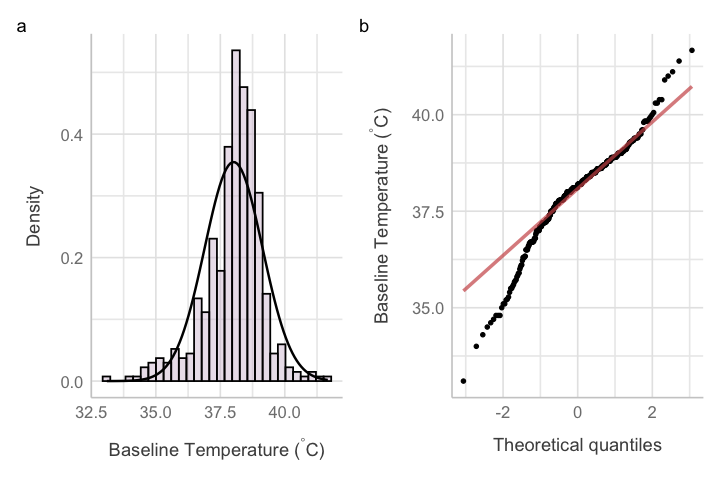

In [9]:
#| label: fig-fig2
#| fig-cap: "Distribution of baseline temperatures for the `Bernard` data set. (a) Histogram with a superimposed normal curve. (b) QQ-plot against the standard normal distribution."
p1 = Bernard |>
  hist_norm(~ temp0, bins = 30, fill = "thistle3") |>
  gf_labs(x = btemp)

p2 = Bernard |>
  qq_plot(~ temp0) |>
  gf_labs(y = btemp)

plots(p1, p2, n_columns = 2, tags = "a")

::: callout-important
## Interpretation

Baseline temperature deviates from normality. Lower temperatures are particularly unlikely to come from a normal distribution.

:::

Our sample is large enough not to worry about small deviations from normality. In healthy subjects, the temperature would be expected to be centred and normally distributed. Later in this lab, when we have concerns about the $t$-test, we will look at options.

## Paired $t$-tests

::: callout-tip
## Example

Let's assume we want to know if there was a significant decrease in the mean temperature at 36 hours in the Placebo group. The $t$-test assumes that data is independent. In this example, the same subjects were measured twice: at baseline and 36 hours. This is a classic example of a paired analysis.

:::

We want to understand what a paired $ t$ test does; therefore, to make things clearer, we will go the long route before performing the test.

::: callout-caution
## Exercise

Calculate the change in temperature from baseline (`temp0`) to 36 hours (`temp10`), calling the new variable `temp_change`. Based on the order of subtraction you used, think about whether an increase in temperature from baseline to 36 hours should be represented by a positive or a negative value in `temp_change` (e.g. I always use Final-Baseline and then interpret the sign: a positive sign implies increase, a negative one, decrease).

:::

In [10]:
#| code-fold: true
Bernard = Bernard |>
  mutate(
    temp_change = temp10 - temp0
  ) |>
  var_labels(
    temp_change = "Temperature change (final - baseline)"
  )

We can estimate the 95% CI of `temp_change`, stratified by treatment group.

In [11]:
Bernard |>
  gen_bst_df(~ temp_change|treat)

Temperature change (final - baseline),LowerCI,UpperCI,Treatment
<dbl>,<dbl>,<dbl>,<fct>
-0.50,-0.64,-0.35,Placebo
-1.03,-1.19,-0.87,Ibuprofen


::: callout-warning
## Question

What do you conclude from the 95% CI for the temperature change in the placebo group?

:::

::: callout-note
## Answer

The mean decrease in temperature from baseline to 36 hr in the placebo group was 0.50 $^{\circ}C$ (95% CI: 0.36 $^{\circ}C$, 0.64 $^{\circ}C$). There was a significant placebo effect as the 95% CI for the temperature change in the placebo group did not include the null value of zero.

:::

We will make a two-sided one-sample $t$-test on temperature change for the placebo group. If we define $\bar x_{cp}$ as the mean temperature change in the placebo group, then our hypotheses are:

-   $H_0: \bar x_{cp}=0$
-   $H_A: \bar x_{cp} \neq 0$


In [12]:
Bernard |>
  filter(treat == "Placebo") |>
  t_test(temp_change ~ 1, detailed = TRUE)

,estimate,.y.,group1,group2,n,statistic,p,df,conf.low,conf.high,method,alternative
,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
mean of x,-0.4985628,temp_change,1,null model,201,-6.816055,1.08e-10,200,-0.6427979,-0.3543277,T-test,two.sided


For a paired test, we do not need to generate the vector of differences (`temp_change`), we just state that the test is paired. The sign of the result will depend on the order of the variables in the command.

If we define $\bar x_{bp}$ as the mean baseline temperature in the placebo group and $\bar x_{fp}$ as the final temperature in the placebo group, our hypotheses are:

-   $H_0: \bar x_{fp} - \bar x_{bp} = 0$
-   $H_0: \bar x_{fp} - \bar x_{bp} \neq 0$

In [14]:
Bernard |>
  filter(treat == "Placebo") |>
  pivot_longer(
    cols = c(temp10, temp0),
    names_to = "Time",
    values_to = "Temperature"
  ) |>
  t_test(Temperature ~ Time, paired = TRUE, detailed = TRUE) |>
  as.data.frame() |>
  sjmisc::round_num(2)

,estimate,.y.,group1,group2,n1,n2,statistic,p,df,conf.low,conf.high,method,alternative
,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0.5,Temperature,temp0,temp10,231,201,6.82,0,200,0.35,0.64,T-test,two.sided


::: callout-tip
## Exercise

Construct a QQ-plot of `temp_change` from subjects in the placebo group, against the standard normal distribution to check for the normality assumption.

:::

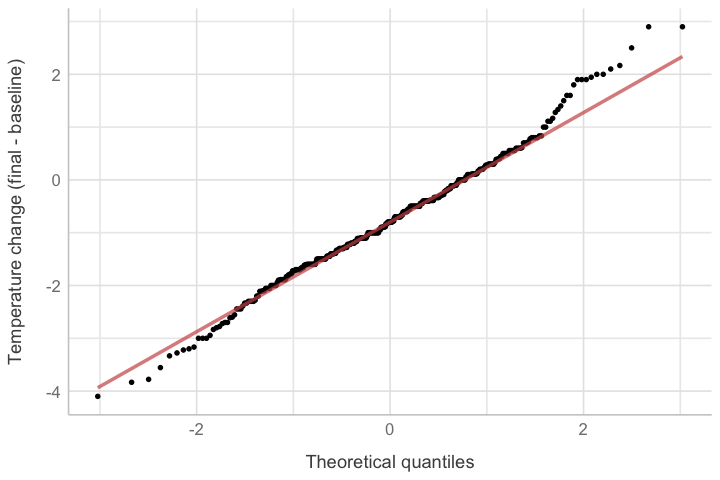

In [15]:
Bernard |>
  select(temp_change) %>% na.omit() |>
  qq_plot(~ temp_change)